In [1]:
%matplotlib inline
#from __future__ import division, print_function
#import sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
#from astropy.coordinates import SkyCoord
from matplotlib.ticker import NullFormatter
#from astropy import units as u
import fitsio
import pandas as pd
from astropy.io import ascii
#from astropy.coordinates import SkyCoord
import sys, os, time, argparse, glob
#import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')

#from desitarget.targetmask import desi_mask
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
#from pyvenn import venn
#from matplotlib_chord_diagram import matplotlib_chord

from desitarget.targetmask import desi_mask, bgs_mask
from main_def import cut_sweeps, cut, load_cat_caseA, load_cat_caseB, load_cat_caseC, load_cat_caseD, get_mag_decals, MASK, unextinct_fluxes, flux_to_mag, matrix_plot, bar_plot, venn_plot, target_con

# Star- Galaxy separation Conditions

Starting point from SWEEPS:

* (200 < RA < 230)   &   (-2 < DEC < 5) --> 200 s.q degrees --> 18960357
* (r < 20) & (Grr > 0.6) | (gaiagmag == 0) --> 356741


Star-Galaxy separation cuts:

* nobs_r > 0
* fracmasked_r < 0.4 
* fracflux_r < 5
* fracin_r > 0.3
* flux_ivar_r > 0
* -1 < g-r < 4
* -1 < r-z < 4
* BRIGHTSTARINBLOB

Total targets for case D: 312430

Total dropped out for case D: 44311

In [2]:
356741 - 312430

44311

### Loading and applying conditions

In [3]:
sweep_dir = os.path.join('/global/project/projectdirs/cosmo/data/legacysurvey/','dr7', 'sweep', '7.1')
catS = cut_sweeps(200, 230, -2,5, sweep_dir)

columns0 = ['RA', 'DEC', 'DESI_TARGET', 'BGS_TARGET']
catT = fitsio.read('targets-dr7.1-0.23.0.fits', columns=columns0, ext=1)
catT = cut(200, 230, -2,5, catT)

sweep-200m005-210p000 1688738
sweep-200p000-210p005 4086987
sweep-210m005-220p000 1739258
sweep-210p000-220p005 4353884
sweep-220m005-230p000 2276054
sweep-220p000-230p005 4815436
Bricks that matched: 6
Sample region # objects: 18960357


In [4]:
cat, catr, cat0, matrix_in, matrix_out, mask_list_MAG, dropped = load_cat_caseA(catS, catT, FILE=False, desitarget=True)

Lenght raw catalogue: 18960357
Lenght DR7 sample within r <= 20: 1030591
Lenght DR7 sample after cuts 887231
adding desitarget and bgstarget column to catalogue...
catS: 18960357
catT: 1557493
Matching...
len idx: 1557493
d2d != 0 0
adding Grr column to catalogue...


gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat)
Grr = cat['Grr'] #Gmag - rr  #rr is without extinction correction
Gmag = cat['GAIA_PHOT_G_MEAN_MAG']

mask_wise = np.logical_and(Grr < 0.4, Grr > -1)
mask_wise &= zmag - w1mag - (gmag - rmag) > -0.5
mask_wise &= cat['FLUX_W1']*np.sqrt(cat['FLUX_IVAR_W1']) > 5
cat_wise = cat[mask_wise]

cat_mag = cat[(Grr > 0.6) | (Gmag == 0)]
del gmag, rmag, zmag, w1mag, Gmag, rr
gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat_mag)

flux = unextinct_fluxes(cat_mag)

#cat_bgs = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0]))

print('#BGS PREV: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_PREV')]), len(cat)))
print('=====================')
print('#BGS FAINT: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_FAINT')]), len(cat_mag[np.logical_and(flux['RFLUX'] <= 10**((22.5-19.5)/2.5), flux['RFLUX'] > 10**((22.5-20.0)/2.5))])))
print('#BGS BRIGHT: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_BRIGHT')]), len(cat_mag[flux_to_mag(flux['RFLUX']) < 19.5])))
print('#BGS WISE: FLUX = %d, MAG = %d' %(len(cat0[MASK(cat0, 'BGS_WISE')]), len(cat_wise)))

In [5]:
#dropped_2 = dropped.drop(['maskFLUX', 'maskMAG'])
#dropped_2 = dropped_2.drop(['PSF_r_per', 'NOPSF_r_per'], axis=1)
#dropped_2.columns = ['drop #', 'drop %']
dropped

,drop_r,drop_r_per,PSF_r_per,NOPSF_r_per
maskNOBS,1288.0,0.124977,62.422360,37.577640
maskMAG,0.0,0.000000,0.000000,0.000000
maskFRACMASKED,97763.0,9.486110,87.121917,12.878083
maskFRACFLUX,31655.0,3.071539,6.760385,93.239615
maskFRACIN,20423.0,1.981678,4.573275,95.426725
maskFLUX_IVAR,512.0,0.049680,72.460938,27.539062
mask_gr,4061.0,0.394046,29.967988,70.032012
mask_rz,5830.0,0.565695,39.365352,60.634648
maskBRIGHTSTAR,26816.0,2.602002,93.928998,6.071002


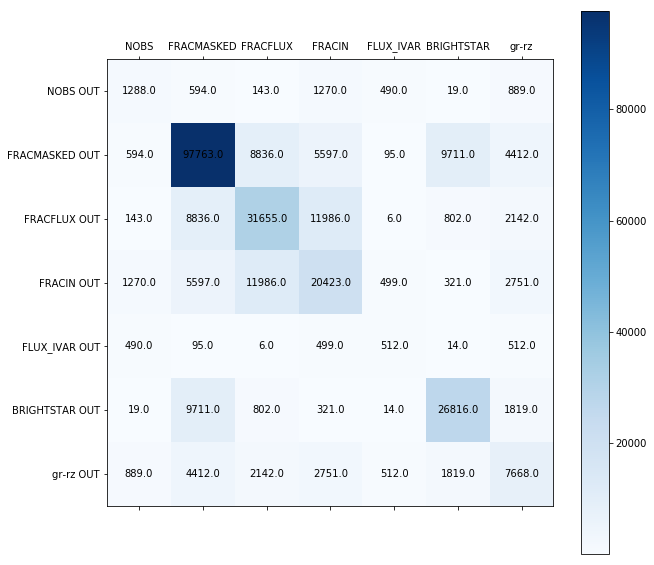

In [6]:
Mu = [[0 for x in range(len(matrix_out))] for y in range(len(matrix_out))] 
    
from itertools import product
for i,j in product(range(len(matrix_out)), range(len(matrix_out))):
    Mu[i][j] = np.array(matrix_out)[i][i] - np.array(matrix_out)[i][j]
    if i == j:
        Mu[i][j] = np.array(matrix_out)[i][j]

    #Mu[i][j] = 100 - 100*np.array(matrix_out)[i][j]/np.array(matrix_out)[i][i]
    #if i == j:
        #Mu[i][j] = 100*np.array(matrix_out)[i][j]/np.array(matrix_out)[i][i]
                    
#matrix_plot(np.array(matrix_out), np.array(matrix_out.index), np.array(matrix_out.columns))
matrix_plot(Mu, np.array(matrix_out.index), np.array(matrix_out.columns))

In [7]:
#df_Mu = pd.DataFrame(Mu, index=matrix_out.index, columns=matrix_out.columns)
#bar_plot(df_Mu)

Objects out alone...
FRACMASKED: 79584
FRACFLUX: 22385
BRIGHTSTAR: 16671
Objects out together...
FRACMASKED-FRACFLUX: 8836
FRACMASKED-BRIGHTSTAR: 9711
FRACFLUX-BRIGHTSTAR: 802
FRACMASKED-FRACFLUX-BRIGHTSTAR: 368
---------------------
136885 objects out of a total 143360 = 95.48 %


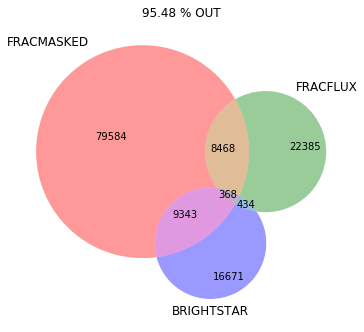

In [8]:
venn_outs_125 = venn_plot(catr, cat, mask_list_MAG, 1, 2, 5, ('FRACMASKED', 'FRACFLUX', 'BRIGHTSTAR'), pos='out', title='OUT')

In [9]:
#catr['RA', 'DEC'][venn_outs_125['FRACFLUX']]

Objects out alone...
FRACMASKED: 85529
FRACFLUX: 13032
FRACIN: 5039
Objects out together...
FRACMASKED-FRACFLUX: 8836
FRACMASKED-FRACIN: 5597
FRACFLUX-FRACIN: 11986
FRACMASKED-FRACFLUX-FRACIN: 2199
---------------------
123422 objects out of a total 143360 = 86.09 %


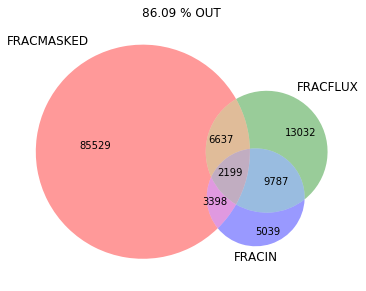

In [10]:
venn_outs_123 = venn_plot(catr, cat, mask_list_MAG, 1, 2, 3, ('FRACMASKED', 'FRACFLUX', 'FRACIN'), pos='out', title='OUT')

Objects out alone...
NOBS: 18
FRACIN: 19144
FLUX_IVAR: 13
Objects out together...
NOBS-FRACIN: 1270
NOBS-FLUX_IVAR: 490
FRACIN-FLUX_IVAR: 499
NOBS-FRACIN-FLUX_IVAR: 490
---------------------
19964 objects out of a total 143360 = 13.93 %


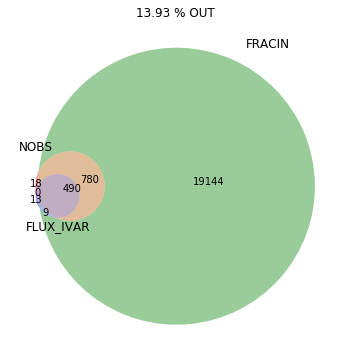

In [11]:
venn_outs_034 = venn_plot(catr, cat, mask_list_MAG,0, 3, 4, ('NOBS', 'FRACIN', 'FLUX_IVAR'), pos='out', title='OUT')

Objects out alone...
FRACIN: 17672
FLUX_IVAR: 0
gr-rz: 4904
Objects out together...
FRACIN-FLUX_IVAR: 499
FRACIN-gr-rz: 2751
FLUX_IVAR-gr-rz: 512
FRACIN-FLUX_IVAR-gr-rz: 499
---------------------
24841 objects out of a total 143360 = 17.33 %


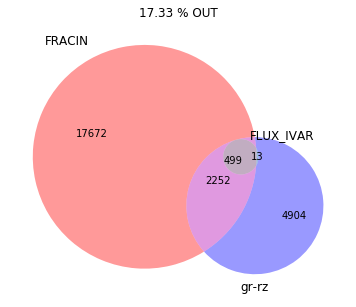

In [12]:
venn_outs_346 = venn_plot(catr, cat, mask_list_MAG,3, 4, 6, ( 'FRACIN', 'FLUX_IVAR', 'gr-rz'), pos='out', title='OUT')

Objects out alone...
FRACMASKED: 18279
FRACIN: 6438
gr-rz: 3527
Objects out together...
FRACMASKED-FRACIN: 11986
FRACMASKED-gr-rz: 2142
FRACIN-gr-rz: 2751
FRACMASKED-FRACIN-gr-rz: 752
---------------------
42867 objects out of a total 143360 = 29.90 %


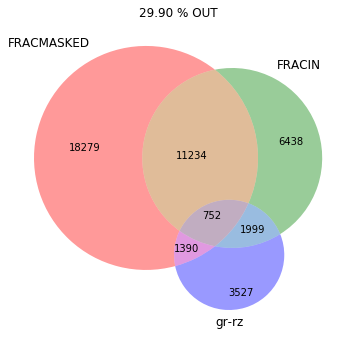

In [ ]:
venn_outs_236 = venn_plot(catr, cat, mask_list_MAG,2,3, 6, ( 'FRACMASKED', 'FRACIN', 'gr-rz'), pos='out', title='OUT')

### Drops in SKY

In [ ]:
for x in (1,2,3,5,6):
    
    plt.figure(figsize=(25.71, 6))
    
    mask_FRAC = [not i for i in mask_list_MAG[x]]
    print(len(catr[mask_FRAC]))
    plt.title(matrix_out.columns[x])
    plt.scatter(catr[mask_FRAC]['RA'], catr[mask_FRAC]['DEC'], s=0.2)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.show()

97763


### PSFSIEZE test

In [ ]:
def psfsize_plot(cat, band=('R')):
    
    psfsize = np.linspace(cat['PSFSIZE_R'].min(), cat['PSFSIZE_R'].max(), 80)
    NPSF = cat[cat['TYPE'] == b'PSF ']

    plt.figure(figsize=(10, 8))

    for j in band:
        NPSF_NTOT = np.zeros(len(psfsize), 'float')
        for i in range(len(psfsize)-1):
            if len(cat[cat['PSFSIZE_'+j] < psfsize[i]]) == 0:
                NPSF_NTOT[i] = 0
            else:
                NPSF_NTOT[i] = len(NPSF[NPSF['PSFSIZE_'+j] < psfsize[i]])/len(cat[cat['PSFSIZE_'+j] < psfsize[i]])
            
        plt.plot(psfsize, NPSF_NTOT, linewidth=2, label=r'PSFSIZE_'+j)

        plt.xlabel(r'PSFSIZE')
        plt.ylabel(r'N(GAIA_GAL+PSF)/N(GAIA_GAL)')
        plt.legend()
        print('band %s done...' %(j))
        
    plt.show()

In [ ]:
psfsize_plot(cat, band=('G', 'R', 'Z'))

### z-w1-(g-r) Vs g-r for 0.6 > Grr 

In [ ]:
def zw1_gr(cat, Grr_min, Grr_max):
    
    GAIA_STAR = cat[np.logical_and(cat['Grr'] < Grr_max, cat['Grr'] > Grr_min)]
    g, r, z, w1, G, rr = get_mag_decals(GAIA_STAR)
    GAIA_STARup =GAIA_STAR[z - w1 - (g - r) > -0.5]
    GAIA_STARdown =GAIA_STAR[z - w1 - (g - r) < -0.5]

    g1, r1, z1, w11, G1, rr1 = get_mag_decals(GAIA_STARup)
    g2, r2, z2, w12, G2, rr2 = get_mag_decals(GAIA_STARdown)

    #GAIA ULTIMATE STARS UP
    gr_psf_up = g1[GAIA_STARup['TYPE'] == b'PSF '] - r1[GAIA_STARup['TYPE'] == b'PSF ']
    zw_psf_up = z1[GAIA_STARup['TYPE'] == b'PSF '] - w11[GAIA_STARup['TYPE'] == b'PSF '] - (gr_psf_up)
    gr_nopsf_up = g1[GAIA_STARup['TYPE'] != b'PSF '] - r1[GAIA_STARup['TYPE'] != b'PSF ']
    zw_nopsf_up = z1[GAIA_STARup['TYPE'] != b'PSF '] - w11[GAIA_STARup['TYPE'] != b'PSF '] - (gr_nopsf_up)
    #GAIA ULTIMATE STARS DOWN
    gr_psf_down = g2[GAIA_STARdown['TYPE'] == b'PSF '] - r2[GAIA_STARdown['TYPE'] == b'PSF ']
    zw_psf_down = z2[GAIA_STARdown['TYPE'] == b'PSF '] - w12[GAIA_STARdown['TYPE'] == b'PSF '] - (gr_psf_down)
    gr_nopsf_down = g2[GAIA_STARdown['TYPE'] != b'PSF '] - r2[GAIA_STARdown['TYPE'] != b'PSF ']
    zw_nopsf_down = z2[GAIA_STARdown['TYPE'] != b'PSF '] - w12[GAIA_STARdown['TYPE'] != b'PSF '] - (gr_nopsf_down)

    plt.figure(figsize=(10, 10))

    plt.scatter(gr_psf_up, zw_psf_up, s=0.01, color='green', label = r'cat & PSF > -0.5, N=%g' %(len(zw_psf_up)))
    plt.scatter(gr_psf_down, zw_psf_down, s=0.01, color='red', label = r'cat & PSF < -0.5, N=%g' %(len(zw_psf_down)))
    
    if len(zw_nopsf_up) > 800:
        s1 = 0.03
    else:
        s1 = 0.5
        
    if len(zw_nopsf_down) > 800:
        s2 = 0.03
    else:
        s2 = 0.5
    
    plt.scatter(gr_nopsf_up, zw_nopsf_up, s=s1, color='blue', label = r'cat & Non-PSF > -0.5, N=%g' %(len(zw_nopsf_up)))
    plt.scatter(gr_nopsf_down, zw_nopsf_down, s=s2, color='blue', label = r'cat & Non-PSF < -0.5, N=%g' %(len(zw_nopsf_down)))
    plt.axhline(-0.5)

    plt.xlabel(r'g-r')
    plt.ylabel(r'z-W-(g-r)')
    plt.title(r'%2.2f > Grr > %2.2f ' %(Grr_max, Grr_min))
    #plt.grid()
    plt.xlim(-1.3, 3.3)
    plt.ylim(-6.3, 4.3)
    lgnd = plt.legend()
    for handle in lgnd.legendHandles:
        handle.set_sizes([14.0])
    
    plt.show()

In [ ]:
zw1_gr(cat, -1, 0.4)

In [ ]:
zw1_gr(cat, 0.4, 0.6)

In [ ]:
zw1_gr(cat, 0.6, 6)

### DESI_TARGET and BGS_TARGET content

### G-r Vs g-z

In [ ]:
#G-r vs g-z
#del gmag, rmag, zmag, w1mag, Gmag
gmag, rmag, zmag, w1mag, Gmag, rr = get_mag_decals(cat)

Grr = cat['Grr'] #Gmag - rr  #rr is without extinction correction
Gmag = cat['GAIA_PHOT_G_MEAN_MAG']

star = cat['TYPE'] == b'PSF ' 
galaxy = cat['TYPE'] != b'PSF '
maskt = Gmag != 0
print('All matchs with GAIA in the sample:',len(cat[maskt]))

plt.figure(figsize=(10, 10))

plt.scatter(gmag[(star) & (maskt)] - zmag[(star) & (maskt)], Gmag[(star) & (maskt)] - rr[(star) & (maskt)], s=0.01, color='red', label = r'PSF, N=%g' %(len(gmag[(star) & (maskt)])))
plt.scatter(gmag[(galaxy) & (maskt)] - zmag[(galaxy) & (maskt)], Gmag[(galaxy) & (maskt)] - rr[(galaxy) & (maskt)], s=0.01, color='blue', label = r'Non-PSF, N=%g' %(len(gmag[(galaxy) & (maskt)])))
plt.axhline(0.6)

plt.xlabel(r'g-z')
plt.ylabel(r'G-rr')
plt.title(r'G != 0')
plt.grid()
lgnd = plt.legend(fontsize=10)
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

#### STAR-GALAXY with GAIA:

* GAIA\_GAL = np.concatenate((cat[Grr $>$ 0.6], cat[Gmag == 0])) 

* GAIA\_STAR = cat[(Grr $<$ 0.6) & (Gmag != 0)]

#### STAR-GALAXY with DECaLS DR7:

* DECALS\_GAL = cat[cat['TYPE'] != b'PSF ']

* DECALS\_STAR = cat[cat['TYPE'] == b'PSF '] 

### r-z Vs g-r 

In [ ]:
#r-z vs g-r

cat_bgs = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0]))
print('cat with Grr > 0.6:',len(cat[Grr > 0.6]))
print('cat with Gmag = 0:',len(cat[Gmag == 0]))
print('concatenate cat:', len(cat_bgs))

g, r, z, w1, G, rr = get_mag_decals(cat_bgs)

Gstar = G[cat_bgs['TYPE'] == b'PSF ']
Ggalaxy = G[cat_bgs['TYPE'] != b'PSF ']

gr_star = g[cat_bgs['TYPE'] == b'PSF '] - r[cat_bgs['TYPE'] == b'PSF ']
rz_star = r[cat_bgs['TYPE'] == b'PSF '] - z[cat_bgs['TYPE'] == b'PSF ']
gr_galaxy = g[cat_bgs['TYPE'] != b'PSF '] - r[cat_bgs['TYPE'] != b'PSF ']
rz_galaxy = r[cat_bgs['TYPE'] != b'PSF '] - z[cat_bgs['TYPE'] != b'PSF ']

#del g1, r1, z1, w11, G1, g, r, z, w1, G, GAIA_STAR
mask_star = np.logical_and(Grr < 0.4, Grr > -1)
GAIA_STAR = cat[mask_star]
g, r, z, w1, G, rr = get_mag_decals(GAIA_STAR)
GAIA_STARup =GAIA_STAR[(z - w1 - (g - r) > -0.5) & (GAIA_STAR['FLUX_W1']*np.sqrt(GAIA_STAR['FLUX_IVAR_W1']) > 5)]
g1, r1, z1, w11, G1, rr1 = get_mag_decals(GAIA_STARup)

plt.figure(figsize=(10, 10))

plt.scatter(gr_galaxy, rz_galaxy, s=0.01, color='green', label = r'Grr>0.6 & non-PSF, N=%g' %(len(gr_galaxy)))
plt.scatter(g1 - r1, r1 - z1, s=0.1, color='cyan', label = r'Grr<0.4 & zw-gr>-0.5 & W1SN>5 %#i' %(len(g1)))
plt.scatter(gr_star[Gstar != 0], rz_star[Gstar != 0], s=0.8, color='red', label = r'Grr>0.6 & PSF & G != 0, N=%g' %(len(gr_star[Gstar != 0])))
plt.scatter(gr_star[Gstar == 0], rz_star[Gstar == 0], s=0.8, color='blue', label = r'Grr>0.6 & PSF & G==0, N=%g' %(len(gr_star[Gstar == 0])))

#plt.scatter(gmag[Gmag == 0] - rmag[Gmag == 0], rmag[Gmag == 0] - zmag[Gmag == 0], s=0.1, color='red')
#plt.scatter(gmag[Grr > 0.9] - rmag[Grr > 0.9], rmag[Grr > 0.9] - zmag[Grr > 0.9], s=0.1, color='black')
plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
#plt.title(r'Grr > 0.6 & !GAIA')
plt.title(r'BGS')
plt.xlim(-1, 2.8)
plt.ylim(-1.5, 3)
plt.grid()
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()


In [ ]:
len(GAIA_STAR)

In [ ]:
# r-z vs g-r
#Grr = Gmag - rmag
GAIA_GAL = np.concatenate((cat[Grr > 0.6], cat[Gmag == 0]))
GAIA_STAR = cat[(Grr  <  0.6) & (Gmag != 0)]

g1, r1, z1, w11, G1, rr1 = get_mag_decals(GAIA_GAL)
g2, r2, z2, w12, G2, rr2 = get_mag_decals(GAIA_STAR)

#GAIA GALAXIES
gr_GAL_psf = g1[GAIA_GAL['TYPE'] == b'PSF '] - r1[GAIA_GAL['TYPE'] == b'PSF ']
rz_GAL_psf = r1[GAIA_GAL['TYPE'] == b'PSF '] - z1[GAIA_GAL['TYPE'] == b'PSF ']
gr_GAL_nopsf = g1[GAIA_GAL['TYPE'] != b'PSF '] - r1[GAIA_GAL['TYPE'] != b'PSF ']
rz_GAL_nopsf = r1[GAIA_GAL['TYPE'] != b'PSF '] - z1[GAIA_GAL['TYPE'] != b'PSF ']

#GAIA STARS
gr_STAR_psf = g2[GAIA_STAR['TYPE'] == b'PSF '] - r2[GAIA_STAR['TYPE'] == b'PSF ']
rz_STAR_psf = r2[GAIA_STAR['TYPE'] == b'PSF '] - z2[GAIA_STAR['TYPE'] == b'PSF ']
gr_STAR_nopsf = g2[GAIA_STAR['TYPE'] != b'PSF '] - r2[GAIA_STAR['TYPE'] != b'PSF ']
rz_STAR_nopsf = r2[GAIA_STAR['TYPE'] != b'PSF '] - z2[GAIA_STAR['TYPE'] != b'PSF ']

plt.figure(figsize=(10, 10))

#plt.scatter(gr_GAL_nopsf, rz_GAL_nopsf, s=0.01, color='blue', label = r'GAIA_GAL & non-PSF, N=%g' %(len(gr_GAL_nopsf)))
#plt.scatter(gr_GAL_psf, rz_GAL_psf, s=0.08, color='red', label = r'GAIA_GAL & PSF, N=%g' %(len(gr_GAL_psf)))

plt.scatter(gr_STAR_psf, rz_STAR_psf, s=0.01, color='red', label = r'GAIA_STAR & PSF, N=%g' %(len(gr_STAR_psf)))
plt.scatter(gr_STAR_nopsf, rz_STAR_nopsf, s=0.8, color='blue', label = r'GAIA_STAR & non-PSF, N=%g' %(len(gr_STAR_nopsf)))

plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
#plt.title(r'')
#plt.grid()
plt.xlim(-1, 2.8)
plt.ylim(-1.5, 3.5)
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
plt.show()

In [ ]:
def target_con(df, NAME):
    
    target_desi = ("BGS_ANY", "QSO", "LRG", "ELG", "BAD_SKY", "NO_TARGET", "BRIGHT_OBJECT", "MWS_ANY", "STD_BRIGHT", "STD_FAINT", "IN_BRIGHT_OBJECT", "NEAR_BRIGHT_OBJECT")
    target_bgs = ("BGS_FAINT", "BGS_BRIGHT")
    print('Total #%s: %g'%(NAME,len(df)))
    print('desitarget matches: %g -- bgstarget matches: %g'%(len(df[df['desitarget'] != 0]) ,len(df[df['bgstarget'] != 0])))
    print('Of which...')
    target_l = []
    for i in target_desi:
        
        target_per = len(df[((np.uint64(df['desitarget']) & np.uint64(desi_mask[i]))!=0)])
        if target_per == 0:
            continue
        print('%s: %2.4g %%' %(i, 100*target_per/len(df)))
        target_l.append([i, 100*target_per/len(df)])
        
    for i in target_bgs:
        
        target_per = len(df[((np.uint64(df['bgstarget']) & np.uint64(bgs_mask[i]))!=0)])
        if target_per == 0:
            continue
        print('%s: %2.4g %%' %(i, 100*target_per/len(df)))
        target_l.append([i, 100*target_per/len(df)])
    
    print('%s: %2.4g %%' %('G==0', 100*len(df[df['GAIA_PHOT_G_MEAN_MAG'] == 0])/len(df)))
    target_l.append(['G==0', 100*len(df[df['GAIA_PHOT_G_MEAN_MAG'] == 0])/len(df)])
    print('%s: %2.4g %%' %('PSF', 100*len(df[df['TYPE'] == b'PSF '])/len(df)))
    target_l.append(['PSF', 100*len(df[df['TYPE'] == b'PSF '])/len(df)])
    print('%s: %2.4g %%' %('no-PSF', 100*len(df[df['TYPE'] != b'PSF '])/len(df)))
    target_l.append(['no-PSF', 100*len(df[df['TYPE'] != b'PSF '])/len(df)])
    print('%s: %2.4g %%' %('desitarget non matches', 100*len(df[df['desitarget'] == 0])/len(df)))
    target_l.append(['desitarget non matches', 100*len(df[df['desitarget'] == 0])/len(df)])
    print('%s: %2.4g %%' %('bgstarget non matches', 100*len(df[df['bgstarget'] == 0])/len(df)))
    target_l.append(['bgstarget non matches', 100*len(df[df['bgstarget'] == 0])/len(df)])
    
    return target_l

In [ ]:
target_cat_bgs = target_con(cat_bgs, 'Grr > 0.6 Or G==0')

In [ ]:
target_GAIA_STAR = target_con(GAIA_STAR, 'Grr < 0.6 + G!=0')

In [ ]:
target_WISE = target_con(GAIA_STARup, 'Grr<0.4 & zw-gr>-0.5 & W1SN>5')

In [ ]:
#Save catalogue for visualization in yymao:https://yymao.github.io/decals-image-list-tool/
t_psf= Table()
t_nopsf= Table()
CAT_PSF = cat_bgs[cat_bgs['TYPE'] == b'PSF ']
CAT_NOPSF = GAIA_STAR[GAIA_STAR['TYPE'] != b'PSF ']
t_psf['ra'] = CAT_PSF['RA']
t_psf['dec'] = CAT_PSF['DEC']
t_nopsf['ra'] = CAT_NOPSF['RA']
t_nopsf['dec'] = CAT_NOPSF['DEC']
ascii.write(t_nopsf[:300], 'separation_NOPSF.dat', overwrite=True)
ascii.write(t_psf[:300], 'separation_PSF.dat', overwrite=True)

## The differences between GAIA and DECaLS BGS classification

* GAIA_GAL + PSF: Compared to the OLD DECaLS classification, this are the new additional objects that get into the New BGS selection.

* GAIA_STAR + no-PSF: Compared to the OLD DECaLS classification, this are the objects that no loonger take part in the New BGS selection.

This means:

    BGS_GAIA = BGS_DECaLS + GAIA_GAL+PSF - GAIA_STAR+NoPSF

In [ ]:
N_BGS_D = len(cat[cat['TYPE'] != b'PSF '])
N_BGS_G = len(GAIA_GAL)
print('BGS_GAIA(%i) = BGS_DECaLS(%i) + GAIA_GAL+PSF(%i) - GAIA_STAR+NoPSF(%i)' %(N_BGS_G, N_BGS_D,len(GAIA_GAL[GAIA_GAL['TYPE'] == b'PSF ']), len(GAIA_STAR[GAIA_STAR['TYPE'] != b'PSF '])))
DIFF = N_BGS_G == N_BGS_D + len(GAIA_GAL[GAIA_GAL['TYPE'] == b'PSF ']) - len(GAIA_STAR[GAIA_STAR['TYPE'] != b'PSF '])

if DIFF:
    print('EVERYTHING MATCH ALRIGHT!')
else:
    print('OPS! SOMETHING DONT MATCH!')

In [ ]:
plt.figure(figsize=(10, 10))
bgs_old = cat['TYPE'] != b'PSF '
gaia_star = GAIA_STAR['TYPE'] != b'PSF '
gaia_gal = GAIA_GAL['TYPE'] == b'PSF '

plt.scatter(gmag[bgs_old] - rmag[bgs_old], rmag[bgs_old] - zmag[bgs_old], s=0.01, color='black', label = r'BGS_DECaLS (keeping in NEW) %#i' %(len(cat[bgs_old])))
plt.scatter(g1[gaia_gal] - r1[gaia_gal], r1[gaia_gal] - z1[gaia_gal], s=0.4, color='blue', label = r'GAIA_GAL+PSF (Adding in NEW)  %#i' %(len(z1[gaia_gal])))
plt.scatter(g2[gaia_star] - r2[gaia_star], r2[gaia_star] - z2[gaia_star], s=0.8, color='red', label = r'GAIA_STAR+noPSF (Throwing in NEW)  %#i' %(len(z2[gaia_star])))
plt.text(-0.8, 2.8, r'BGS_GAIA = BGS_DECaLS + GAIA_GAL+PSF - GAIA_STAR+NoPSF')

plt.xlabel(r'g-r')
plt.ylabel(r'r-z')
#plt.title(r'Grr > 0.6 & !GAIA')
plt.title(r'comparisons between BGS with DECaLS (OLD) and BGS with GAIA (NEW)')
plt.xlim(-1, 2.8)
plt.ylim(-1.5, 3)
plt.grid()
lgnd = plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(t_psf['ra'], t_psf['dec'], s=2, color='red', label = r'GAIA GAL + PSF, N=%g' %(len(t_psf)))
plt.scatter(t_nopsf['ra'], t_nopsf['dec'], s=2, color='blue', label = r'GAIA STAR + NOPSF, N=%g' %(len(t_nopsf)))
plt.legend()

In [ ]:
#CAT_PSF is just GAIA GAL & PSF
#CAT_NOPSF is GAIA STAR & NoPSF

bins = np.linspace(0.95, 2.5, 50)
bands = ('R', 'G', 'Z')
for i in bands:
    plt.figure(figsize=(12, 7))
    plt.hist(CAT_PSF['PSFSIZE_'+i], bins=bins, label=r'GAIA GAL & PSF')
    plt.hist(CAT_NOPSF['PSFSIZE_'+i], bins=bins, label=r'GAIA STAR & No-PSF')
    plt.xlabel(r'PSFSIZE_'+i)
    plt.legend()
    plt.show()

## DESI_TARGET and BGS_TARGET

In [ ]:
target_CAT_NOPSF = target_con(CAT_NOPSF, 'GAIA STAR + NOPSF')

In [ ]:
target_CAT_PSF = target_con(CAT_PSF, 'GAIA GAL + PSF')

### Ratio of galaxies and Stars defined by GAIA and DECaLS

In [ ]:
r_tmp = np.linspace(15.01,20,40)
frac_gal = np.zeros(len(r_tmp), dtype='f8')
frac_star = frac_gal.copy()
frac_decals_gal = frac_gal.copy()
frac_decals_star = frac_gal.copy()
frac_gaia_gal = frac_gal.copy()
frac_gaia_star = frac_gal.copy()

del g,r,z, w1, G, rr
g, r, z, w1, G, rr = get_mag_decals(cat)
j = 0
for i in r_tmp:
    #DECALS_GAL = cat[cat['TYPE'] != b'PSF ']
    #DECALS_STAR = cat[cat['TYPE'] == b'PSF ']
    #DECALS_GAL = cat[r <= i]
    #DECALS_STAR = cat[r <= i]
    
    Ntot = len(cat[r <= i])
    NDECALS_GAL = len(cat[(cat['TYPE'] != b'PSF ') & (r <= i)])
    NDECALS_STAR = len(cat[(cat['TYPE'] == b'PSF ') & (r <= i)])
    NGAIA_GAL = len(GAIA_GAL[r1 <= i])
    NGAIA_STAR = len(GAIA_STAR[r2 <= i])
    
    frac_gal[j] = NDECALS_GAL/NGAIA_GAL
    frac_star[j] = NDECALS_STAR/NGAIA_STAR
    frac_decals_gal[j] = NDECALS_GAL/Ntot
    frac_decals_star[j] = NDECALS_STAR/Ntot
    frac_gaia_gal[j] = NGAIA_GAL/Ntot
    frac_gaia_star[j] = NGAIA_STAR/Ntot
    
    j = j + 1

plt.figure(figsize=(10, 6))

plt.axhline(1, color='red')
plt.plot(r_tmp, frac_gal, marker='o', label=r'frac_gal')
plt.plot(r_tmp, frac_star, marker='o', label=r'frac_star')

plt.xlabel(r'r')
plt.ylabel(r'$f$ (DECALS/GAIA)')
lgnd = plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(r_tmp, frac_decals_gal, marker='o', label=r'frac_decals_gal')
plt.plot(r_tmp, frac_decals_star, marker='o', label=r'frac_decals_star')
plt.plot(r_tmp, frac_gaia_gal, linestyle='--', label=r'frac_gaia_gal')
plt.plot(r_tmp, frac_gaia_star, linestyle='--', label=r'frac_gaia_star')

plt.xlabel(r'r')
plt.ylabel(r'$f$/Ntot')
lgnd = plt.legend()
plt.show()

In [ ]:
print('GAIA_STAR + No-PSF content:')
GAIA_STAR_TYPE = pd.DataFrame(GAIA_STAR['TYPE'])
print(GAIA_STAR_TYPE[GAIA_STAR_TYPE != b'PSF ']['TYPE'].value_counts())
print('---------------------------------')
print('GAIA_GAL + PSF content:')
GAIA_GAL_TYPE = pd.DataFrame(GAIA_GAL['TYPE'])
print(GAIA_GAL_TYPE[GAIA_GAL_TYPE[0] == b'PSF '][0].value_counts())